In [17]:
import shap
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_returns = pd.read_csv("1960-2023returns.csv")
df_returns['date'] = pd.to_datetime(df_returns["date"])
df_returns['date'] = df_returns['date'].apply(lambda dt: dt.replace(day=1))

In [3]:
df_returns = df_returns.sort_values(by = "date")
df_returns_train = df_returns[df_returns["date"] <= "1970-01-01"]

In [4]:
#rank each month
df_returns_train.rename(columns={"PERMNO": "permno"}, inplace=True)

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_49236/316601147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns_train.rename(columns={"PERMNO": "permno"}, inplace=True)


In [5]:
df_recent_train = pd.read_csv("2000-2010Training.csv")
df_recent_returns_train = df_returns[df_returns["date"] >= "2000-01-01"]
df_recent_returns_train =  df_returns[df_returns["date"]<="2009-12-01"]
df_recent_train['yyyymm'] = pd.to_datetime(df_recent_train['yyyymm'],format = "%Y%m")
df_recent_train['yyyymm'] = df_recent_train['yyyymm'].apply(lambda dt: dt.replace(day=1))
df_recent_returns_train.rename(columns={"PERMNO":"permno"}, inplace=True)

df_recent_train.rename(columns={'yyyymm': 'date'}, inplace=True)
intersection_df_recent = pd.merge(df_recent_train, df_recent_returns_train, how='inner', on=['permno', 'date'])
intersection_df_recent['Year'] = intersection_df_recent['date'].dt.year
intersection_df_recent['Month'] = intersection_df_recent['date'].dt.month
intersection_df_recent['RET'] = pd.to_numeric(intersection_df_recent["RET"], errors='coerce')
intersection_df_recent['Quintile'] = intersection_df_recent.groupby(['Year', 'Month'])['RET'].transform(
    lambda x: pd.qcut(x, 5, labels=False)
)
intersection_df_recent = intersection_df_recent.sort_values(by=["permno", "date"])
intersection_df_recent["New Y"] = intersection_df_recent.groupby(["permno"])["Quintile"].shift(-1)

#intersection_df_recent.dropna(subset = ['Quintile'], inplace=True)
intersection_df_recent.dropna(subset = ['New Y'], inplace=True)
drop_from_df = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Month", "Unnamed: 0", "New Y"]
Y_recent = intersection_df_recent["New Y"]
X_recent = intersection_df_recent.drop(columns=drop_from_df)

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_49236/509265197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent_returns_train.rename(columns={"PERMNO":"permno"}, inplace=True)


In [6]:
xgc_recent = XGBClassifier()
xgc_recent.fit(X_recent, Y_recent)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [7]:
#data cleaning, merging returns and features datasets
def to_intersect(file, df_returns):
    df = pd.read_csv(file)
    df['yyyymm'] = pd.to_datetime(df['yyyymm'],format = "%Y%m")
    df['yyyymm'] = df['yyyymm'].apply(lambda dt: dt.replace(day=1))
    dfRET = df_returns[df_returns["date"] >= df['yyyymm'].min()]
    dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]
    dfRET.rename(columns={"PERMNO":"permno"}, inplace=True)
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    df.rename(columns={'yyyymm': 'date'}, inplace=True)
    intersection = pd.merge(df, dfRET, how='inner', on=['permno', 'date'])
    intersection['Year'] = intersection['date'].dt.year
    intersection['Month'] = intersection['date'].dt.month
    intersection['RET'] = pd.to_numeric(intersection["RET"], errors='coerce')
    intersection['Quintile'] = intersection.groupby(['Year', 'Month'])['RET'].transform(
        lambda x: pd.qcut(x, 5, labels=False)
    )
    intersection = intersection.sort_values(by=["permno", "date"])
    intersection["New Y"] = intersection.groupby(["permno"])["Quintile"].shift(-1)
    intersection.dropna(subset = ['New Y'], inplace=True)
    intersection["New RET"] = intersection.groupby(["permno"])["RET"].shift(-1)
    intersection.dropna(subset = ["New RET"], inplace=True)
    return intersection

In [8]:
def to_X_Y(intersect):
    intersect.dropna(subset = ['New Y'], inplace=True)
    drop_from_df = ["permno", "date", "RET", "RETX", "Quintile", "Year", "Month", "Unnamed: 0", "New Y", "New RET"]
    Y = intersect["New Y"]
    X = intersect.drop(columns=drop_from_df)
    return [X, Y]

In [9]:
X_Y_2011 = to_X_Y(to_intersect("2011Test.csv", df_returns))
X_test = X_Y_2011[0]

/var/folders/sz/ts8tdp9n3f133bj7r6__4w7h0000gn/T/ipykernel_49236/2730922712.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfRET =  dfRET[df_returns["date"]<=df['yyyymm'].max()]


In [10]:
explainer = shap.TreeExplainer(xgc_recent)
shap_values = explainer(X_test)

In [19]:
shap.plots.bar(shap_values.shap_values)

AttributeError: 'Explanation' object has no attribute 'shap_values'

In [28]:
shap_values

.values =
array([[[-2.68957368e-03,  3.21664527e-04, -4.48274426e-03,
          5.79252373e-04, -8.51531979e-04],
        [ 3.22332024e-04, -7.30238040e-04, -3.94279230e-03,
         -2.12961240e-04,  7.64652272e-04],
        [-7.79982237e-03, -6.18244696e-04,  5.19463210e-05,
         -1.17004878e-04, -7.11518165e-04],
        ...,
        [-3.22279916e-03,  1.67955656e-03, -1.30450726e-03,
          2.80644698e-03, -1.86157739e-03],
        [-1.02565512e-02,  1.93170051e-03, -2.69511342e-03,
          3.60014994e-04,  9.05991474e-04],
        [-4.96642524e-03,  2.34996923e-03,  9.92755312e-03,
         -1.88126438e-03,  6.63833506e-03]],

       [[ 8.19682144e-04, -1.87043683e-04, -4.53547155e-03,
          4.45223501e-04, -1.09969568e-03],
        [ 1.83653878e-03, -9.67210392e-04, -3.96923861e-03,
         -1.15863360e-04,  7.34028872e-04],
        [-3.91376344e-03, -6.50192902e-04,  2.18207439e-04,
         -3.61851125e-04, -8.22505273e-04],
        ...,
        [ 1.20687194e-03, 

TypeError: only integer scalar arrays can be converted to a scalar index

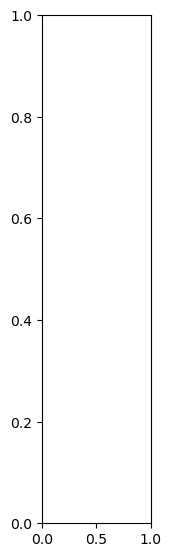

In [32]:
shap.summary_plot(shap_values, X_test, feature_names=shap_values.feature_names)

In [ ]:

# For a single prediction using the first index
# Make sure you access the elements correctly:
# For a specific output (e.g., the first output in a multi-class model)
shap.plots.force(explainer.expected_value[0], shap_values.values[..., 0])



/Users/dylanshih/anaconda3/lib/python3.11/site-packages/shap/plots/_force.py:208: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


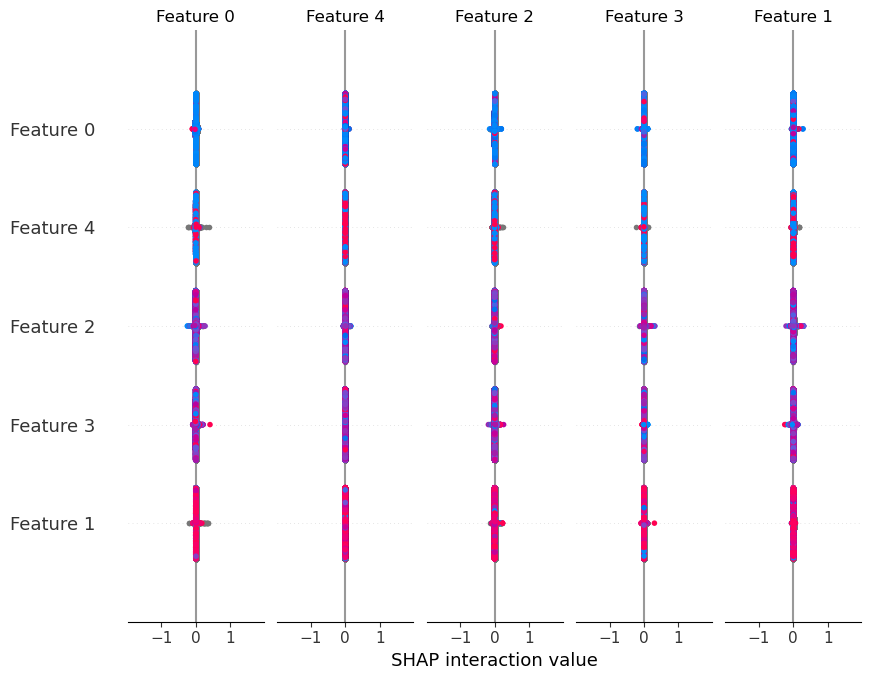

In [12]:
# If X_test is a DataFrame and you encounter issues, try:
shap.summary_plot(shap_values.values, X_test.values)


In [13]:
print(type(shap_values))
print(shap_values.shape) 

<class 'shap._explanation.Explanation'>
(66037, 209, 5)


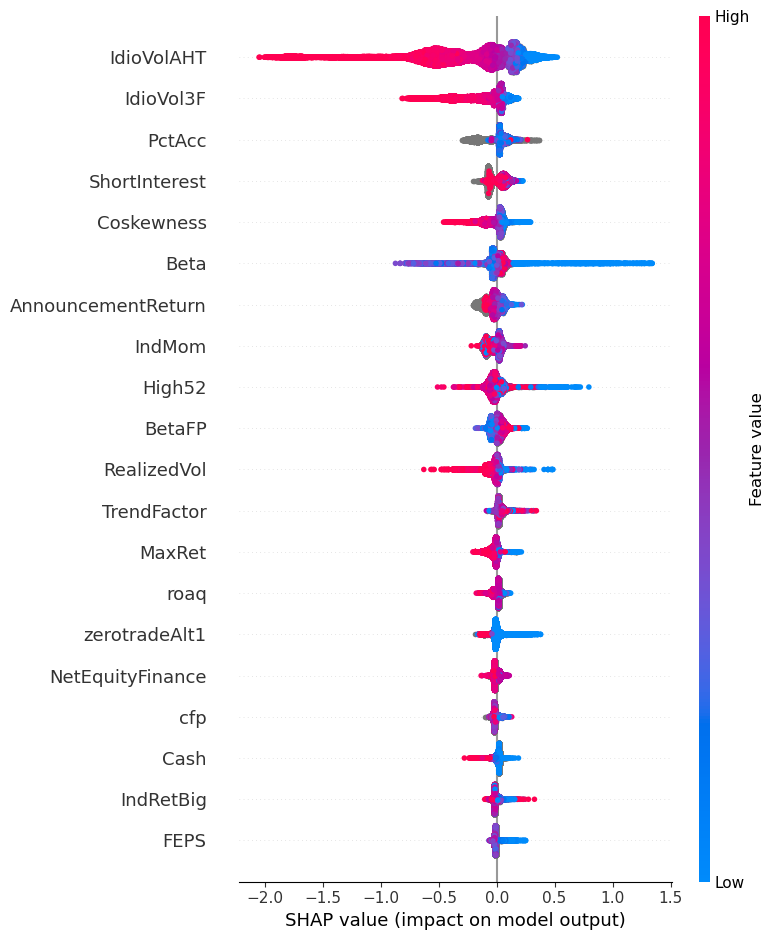

In [15]:
# Selecting SHAP values for the first class
shap_values_class_0 = shap_values.values[..., 0]  # Using numpy slicing to get all rows, all features for class 0
# Plotting summary plot for the selected class
shap.summary_plot(shap_values_class_0, X_test.values, feature_names=X_test.columns)


In [20]:
# Iterate over each class to plot SHAP values separately
for i in range(shap_values.values.shape[2]):  # Assuming the last dimension represents the class/output
    shap_values_for_class = shap_values.values[..., i]
    plt.figure()
    plt.title(f'SHAP Summary Plot for Class {i}')
    shap.summary_plot(shap_values_for_class, X_test, show=False)
    plt.savefig(f'shap_summary_class_{i}.png')  # Save the figure to a file
    plt.close()  # Close the figure to free up memory
